In [29]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Device: {device}")


Device: mps


In [30]:
df = pd.read_csv('../data/balanced_animals_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(df['scientific_name'].value_counts())


Dataset shape: (12000, 6)
scientific_name
Canis aureus              2400
Canis familiaris          2400
Canis familiaris dingo    2400
Canis latrans             2400
Canis lupus               2400
Name: count, dtype: int64


In [31]:
label_to_idx = {label: idx for idx, label in enumerate(df['scientific_name'].unique())}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
df['label'] = df['scientific_name'].map(label_to_idx)

print(f"Classes: {len(label_to_idx)}")
print(label_to_idx)


Classes: 5
{'Canis aureus': 0, 'Canis familiaris': 1, 'Canis familiaris dingo': 2, 'Canis latrans': 3, 'Canis lupus': 4}


In [32]:
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=42
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}")
print(train_df['scientific_name'].value_counts())


Train: 9600, Val: 2400
scientific_name
Canis familiaris          1920
Canis familiaris dingo    1920
Canis aureus              1920
Canis latrans             1920
Canis lupus               1920
Name: count, dtype: int64


In [33]:
class AnimalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.base_path = Path('../animal_images')
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        species = row['scientific_name'].replace(' ', '_')
        img_path = self.base_path / species / f"{row['uuid']}.jpg"
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            image = Image.new('RGB', (224, 224), color=(0, 0, 0))
            
        label = row['label']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [34]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [35]:
train_dataset = AnimalDataset(train_df, transform=train_transform)
val_dataset = AnimalDataset(val_df, transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


Train batches: 300
Val batches: 75


In [36]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(label_to_idx))

model = model.to(device)


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [38]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [39]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [40]:
num_epochs = 10
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0
Path('../models').mkdir(exist_ok=True)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '../models/best_model.pth')
        print(f"Best model saved with val_acc: {val_acc:.2f}%")
    
    scheduler.step()



Epoch 1/10


Validation: 100%|██████████| 75/75 [00:16<00:00,  4.68it/s]


Train Loss: 1.1558, Train Acc: 53.92%
Val Loss: 0.9516, Val Acc: 64.75%
Best model saved with val_acc: 64.75%

Epoch 2/10


Validation: 100%|██████████| 75/75 [00:15<00:00,  4.98it/s]


Train Loss: 1.0002, Train Acc: 61.41%
Val Loss: 1.0044, Val Acc: 61.79%

Epoch 3/10


Validation: 100%|██████████| 75/75 [00:15<00:00,  4.99it/s]


Train Loss: 0.9868, Train Acc: 62.25%
Val Loss: 0.9408, Val Acc: 64.17%

Epoch 4/10


Validation: 100%|██████████| 75/75 [00:15<00:00,  4.98it/s]


Train Loss: 0.9178, Train Acc: 64.96%
Val Loss: 0.9227, Val Acc: 66.04%
Best model saved with val_acc: 66.04%

Epoch 5/10


Validation: 100%|██████████| 75/75 [00:15<00:00,  4.99it/s]


Train Loss: 0.9056, Train Acc: 65.75%
Val Loss: 0.9098, Val Acc: 66.79%
Best model saved with val_acc: 66.79%

Epoch 6/10


Validation: 100%|██████████| 75/75 [00:14<00:00,  5.02it/s]


Train Loss: 0.9015, Train Acc: 65.48%
Val Loss: 0.9133, Val Acc: 66.08%

Epoch 7/10


Validation: 100%|██████████| 75/75 [00:15<00:00,  4.98it/s]


Train Loss: 0.8917, Train Acc: 66.28%
Val Loss: 0.9012, Val Acc: 66.67%

Epoch 8/10


Validation: 100%|██████████| 75/75 [00:15<00:00,  4.97it/s]


Train Loss: 0.9024, Train Acc: 66.04%
Val Loss: 0.9032, Val Acc: 67.08%
Best model saved with val_acc: 67.08%

Epoch 9/10


Validation: 100%|██████████| 75/75 [00:15<00:00,  4.96it/s]


Train Loss: 0.8933, Train Acc: 66.25%
Val Loss: 0.8995, Val Acc: 67.46%
Best model saved with val_acc: 67.46%

Epoch 10/10


Validation: 100%|██████████| 75/75 [00:15<00:00,  4.98it/s]

Train Loss: 0.8942, Train Acc: 65.78%
Val Loss: 0.8965, Val Acc: 67.21%


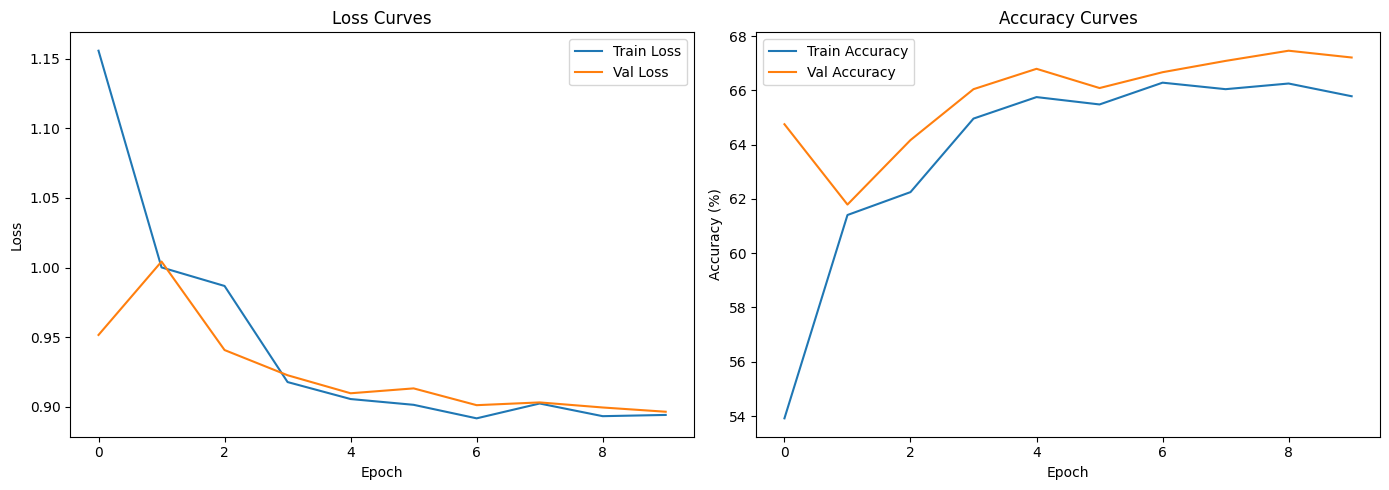

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss Curves')

ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy Curves')

plt.tight_layout()
plt.savefig('../docs/training_curves.png', dpi=300)
plt.show()


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


In [45]:
print(classification_report(
    all_labels, 
    all_preds, 
    target_names=[idx_to_label[i] for i in range(len(idx_to_label))]
))


                        precision    recall  f1-score   support

          Canis aureus       0.65      0.69      0.67       480
      Canis familiaris       0.81      0.69      0.74       480
Canis familiaris dingo       0.73      0.72      0.73       480
         Canis latrans       0.58      0.53      0.55       480
           Canis lupus       0.62      0.74      0.67       480

              accuracy                           0.67      2400
             macro avg       0.68      0.67      0.67      2400
          weighted avg       0.68      0.67      0.67      2400



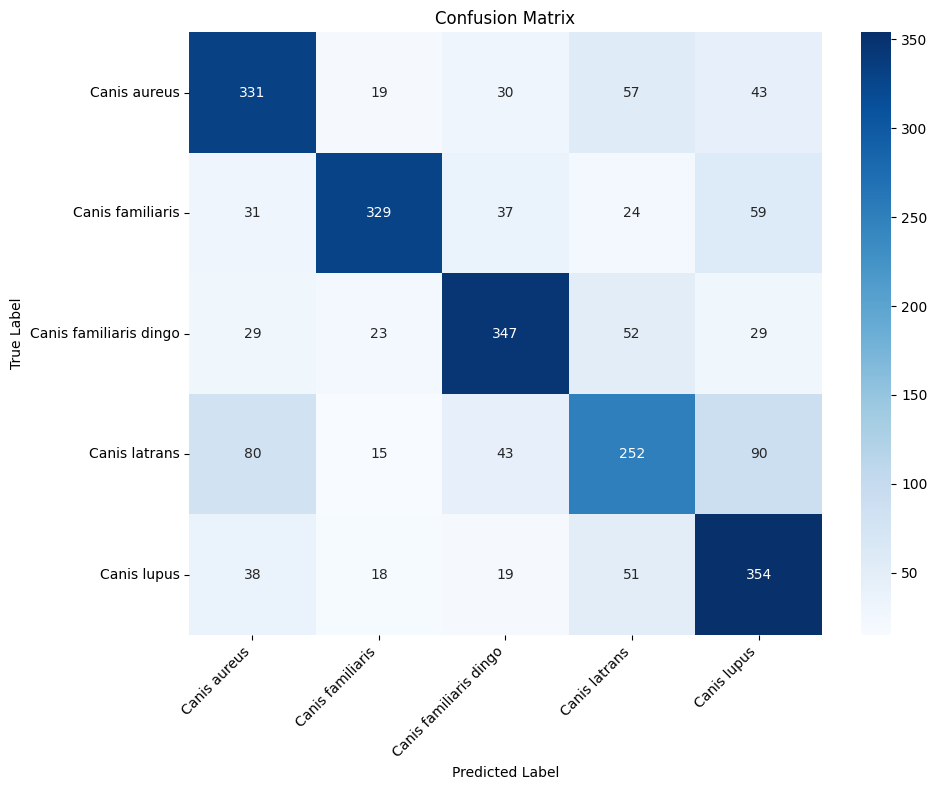

In [46]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=[idx_to_label[i] for i in range(len(idx_to_label))],
    yticklabels=[idx_to_label[i] for i in range(len(idx_to_label))]
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../docs/confusion_matrix.png', dpi=300)
plt.show()


In [47]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'label_to_idx': label_to_idx,
    'idx_to_label': idx_to_label,
    'history': history,
    'best_val_acc': best_val_acc
}, '../models/final_checkpoint.pth')

print(f"Final checkpoint saved. Best validation accuracy: {best_val_acc:.2f}%")


Final checkpoint saved. Best validation accuracy: 67.46%


In [48]:
Path('../models').mkdir(exist_ok=True)


In [49]:
import json

metrics = {
    'best_val_accuracy': best_val_acc,
    'final_train_accuracy': history['train_acc'][-1],
    'final_val_accuracy': history['val_acc'][-1],
    'final_train_loss': history['train_loss'][-1],
    'final_val_loss': history['val_loss'][-1],
    'num_epochs': num_epochs,
    'num_classes': len(label_to_idx)
}

with open('../metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print("Metrics saved")


Metrics saved
